<a href="https://colab.research.google.com/github/solobala/TSML13/blob/main/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 3
## Модели ARIMA и GARCH

In [1]:
!pip install statsmodels

In [31]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from scipy.stats import boxcox
from math import sqrt
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [6]:
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/TSML13_DZ1'
SERIES = Path(ROOT, 'Series')

Mounted at /content/drive


## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                -1.846521e+01
p-value                        2.143848e-30
#Lags Used                     2.000000e+00
Number of Observations Used    9.970000e+02
Critical Value (1%)           -3.436926e+00
Critical Value (5%)           -2.864443e+00
Critical Value (10%)          -2.568316e+00
dtype: float64


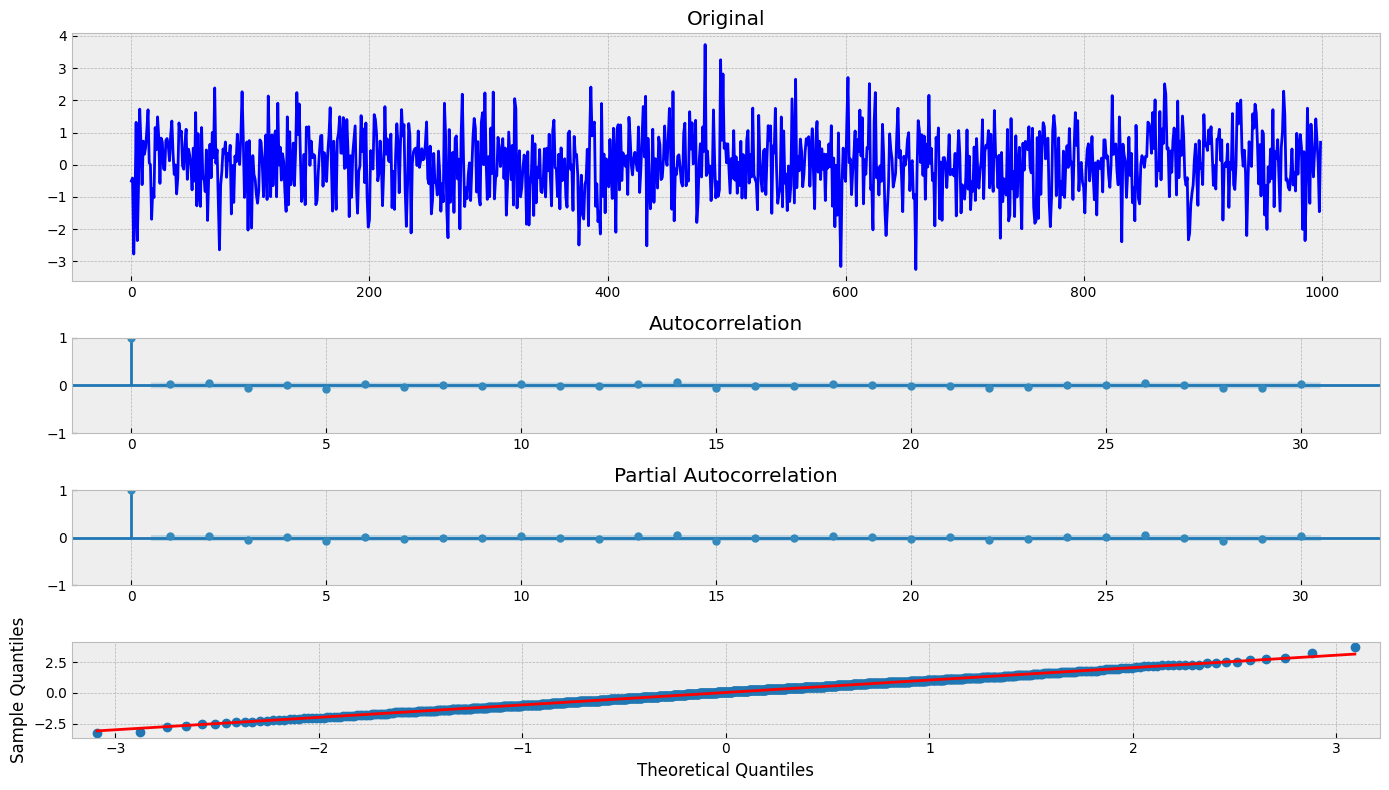

In [ ]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [ ]:
# np.sort(randser)

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

In [ ]:
n_samples = 100

In [ ]:
eps = np.random.normal(size=n_samples)
x = [0 + eps[0]]
for i in range(1, n_samples):
    x.append(x[i-1] + eps[i])

In [ ]:
x = np.array(x)

Results of Dickey-Fuller Test:
Test Statistic                 -1.892210
p-value                         0.335735
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


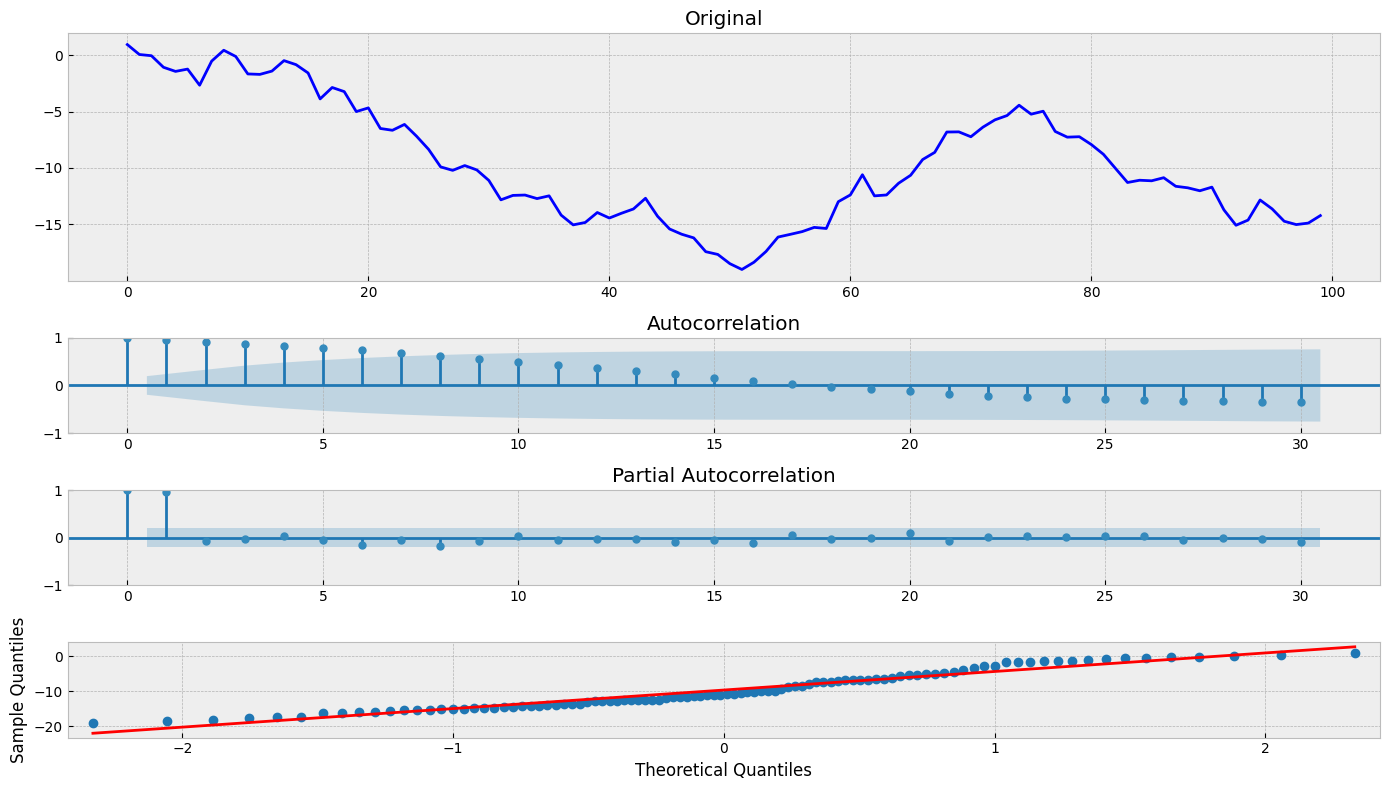

In [ ]:
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -1.293986
p-value                          0.631919
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


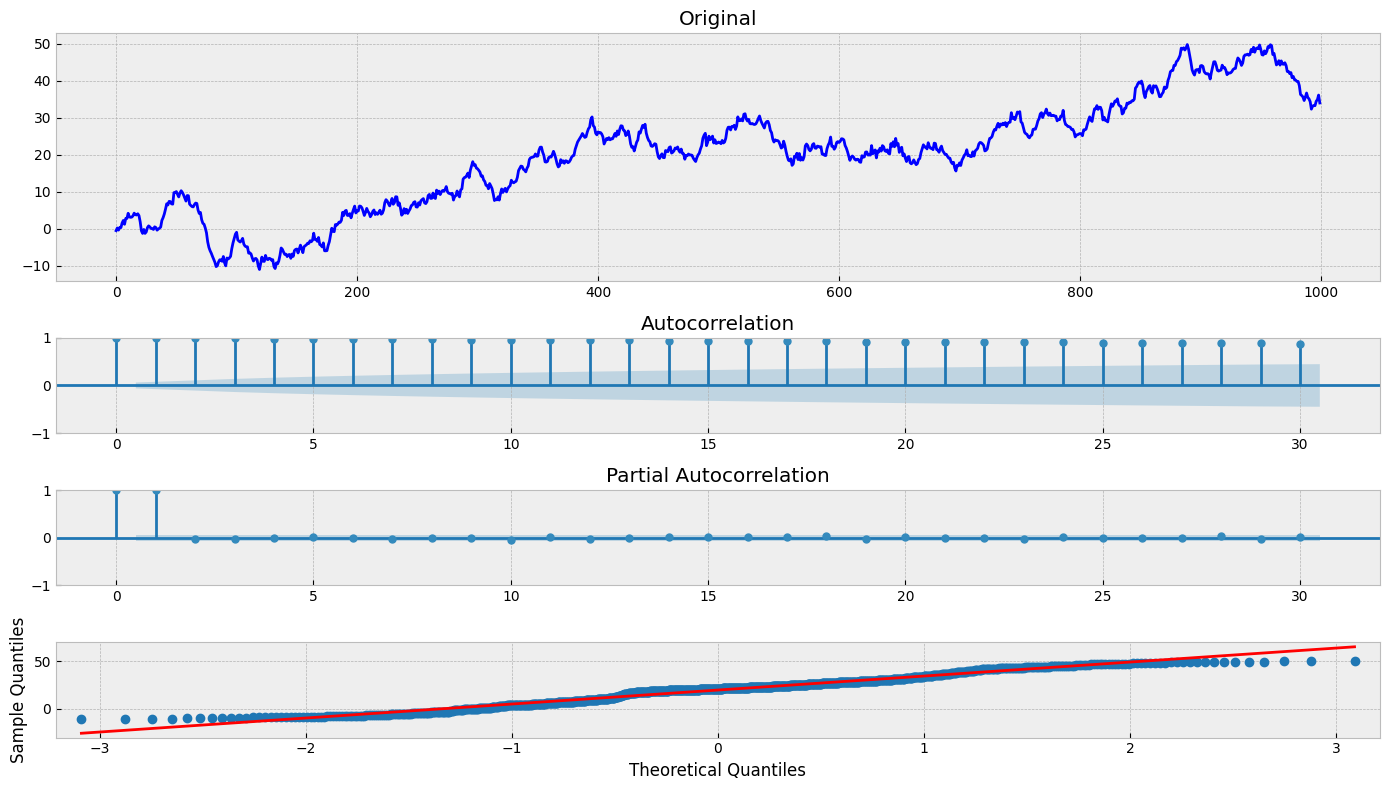

In [ ]:
# Сгенерируем данные
x = np.random.normal(size=1000)
x = np.cumsum(x)
tsplot(x, lags=30)

Давайте проверим, подходит ли модель случайного блуждания под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                 -30.404288
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


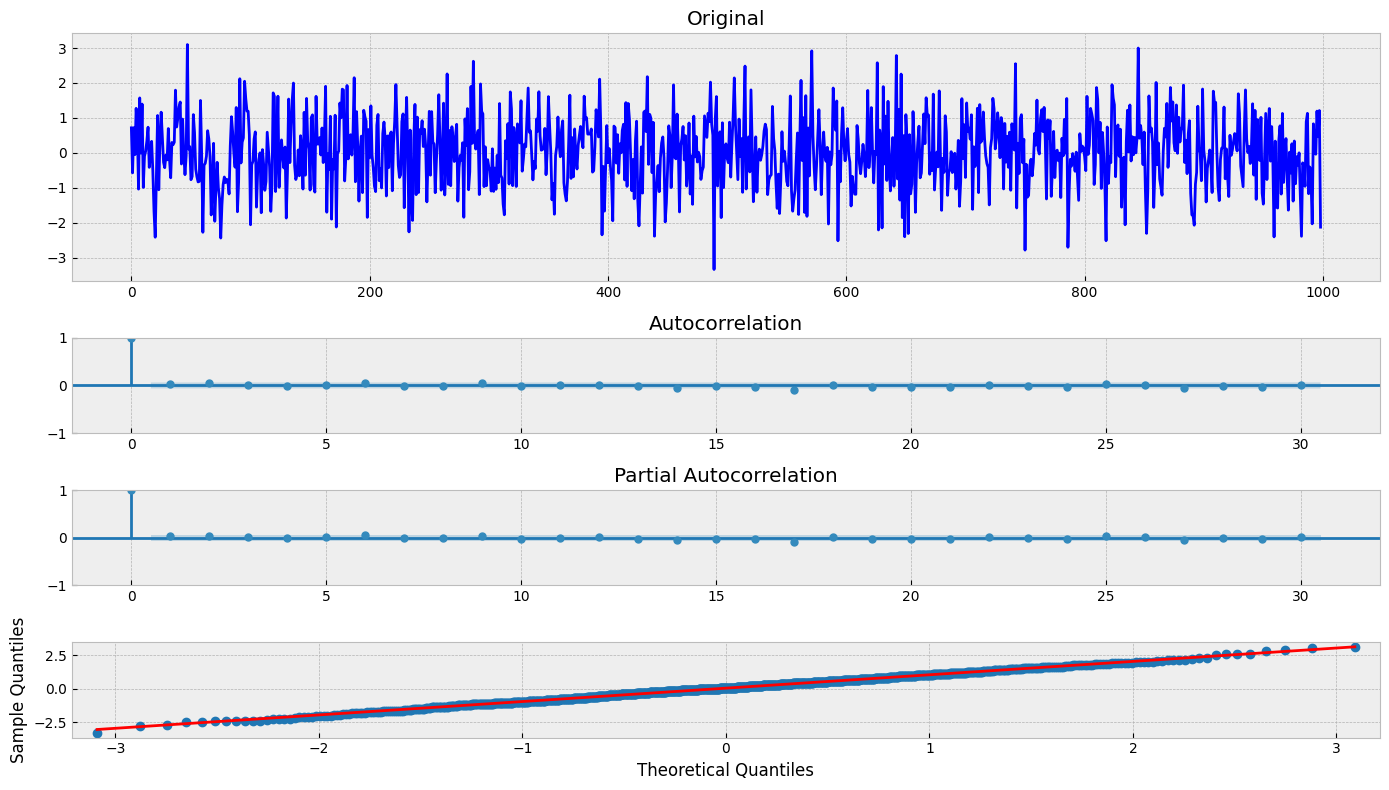

In [ ]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

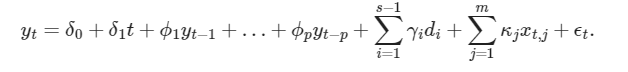

в общем виде авторегрессионная модель подходит для: рядов с /Без тренда, тренд может быть постоянным (c), линейно меняющимся во времени (delta0 + delta1*t) -(ct),(n) -без тренда, t - без константы
di - сезонность, xtj - независимая переменная

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


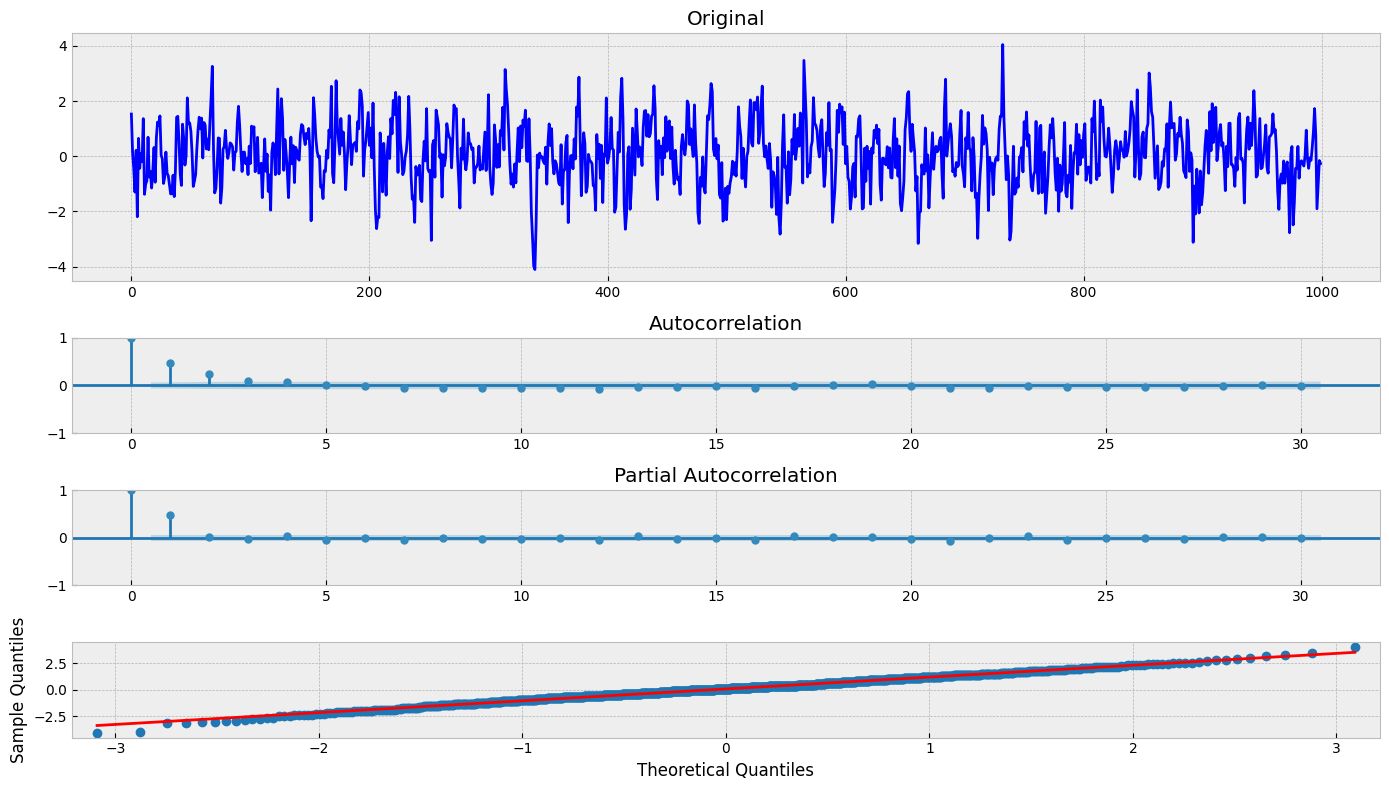

In [ ]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]

tsplot(x, lags=30)

In [ ]:
# строим Модель авторегрессии AR(1) - в ряде нет тренда и сезонности
mod = AutoReg(endog=x, lags=1, trend='n', seasonal=False, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1000
Model:                     AutoReg(1)   Log Likelihood               -1398.031
Method:               Conditional MLE   S.D. of innovations              0.981
Date:                Mon, 20 Nov 2023   AIC                           2800.062
Time:                        20:37:18   BIC                           2809.876
Sample:                             1   HQIC                          2803.792
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.4808      0.028     17.350      0.000       0.426       0.535
                                    Roots                                    
                  Real          Imaginary           M

In [ ]:
# Это функция, которая пытается подобрать порядок для AR_модели
sel = ar_select_order(endog=x, maxlag=3, ic='aic', trend='n', seasonal=False, glob=True, old_names=False)
print(sel.ar_lags)


[1]


In [ ]:
est_order = sel.ar_lags[0] # Это порядок, пообранный функцией ar_select_order
true_order = 1 # Это используемый при генерации данных порядок модели
# res.params - коэффициенты модели ( в данном случае только один, поэтому res.params[0])
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(res.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.48076 | best lag order = 1

true alpha = 0.5 | true order = 1


Results of Dickey-Fuller Test:
Test Statistic                 -31.856304
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


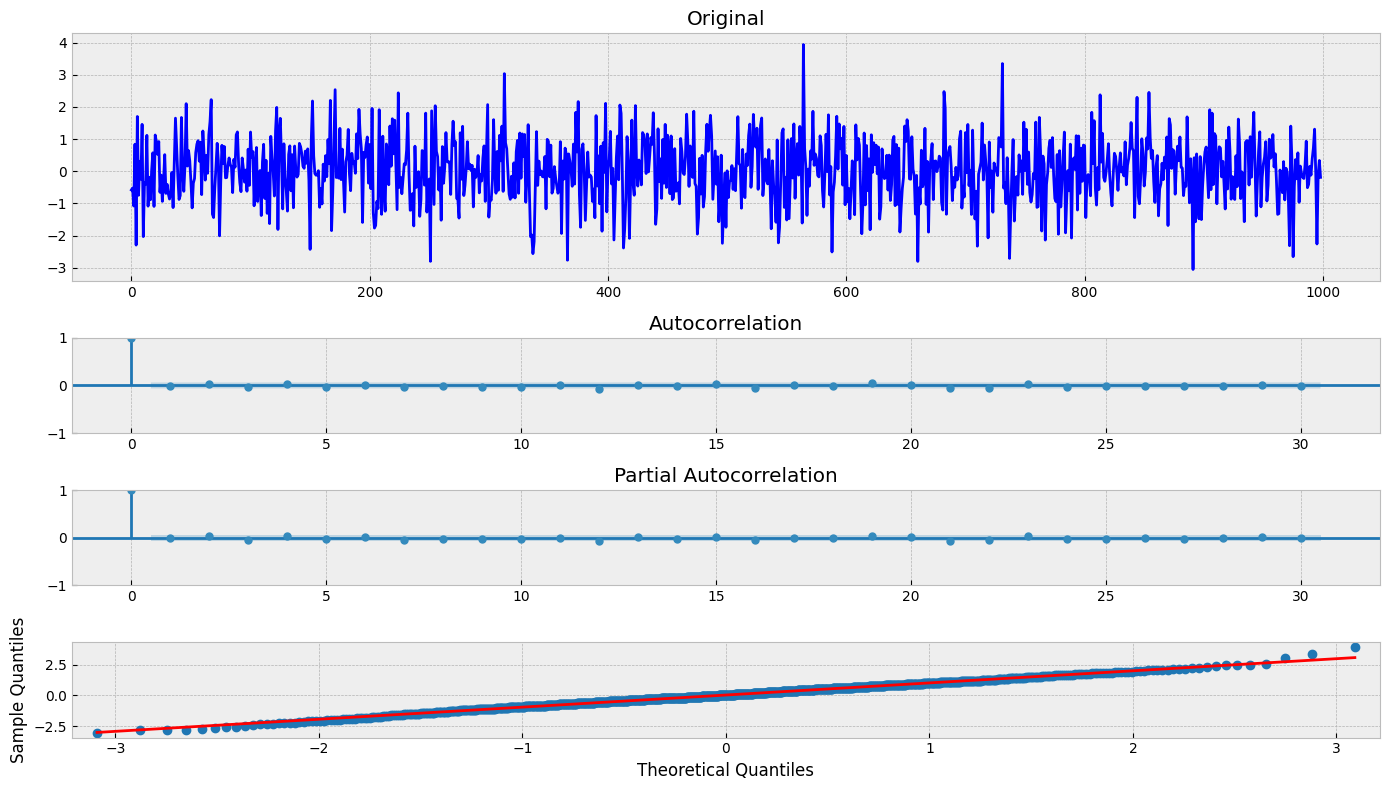

In [ ]:
# график остатков - фактически, график шума
tsplot(res.resid, lags=30)

Визуально - белый шум, тести дики-фуллера  подтверждает стационарность, коррелограмма - как у стационарного ряда, qq график -нормальное распределение остатков

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


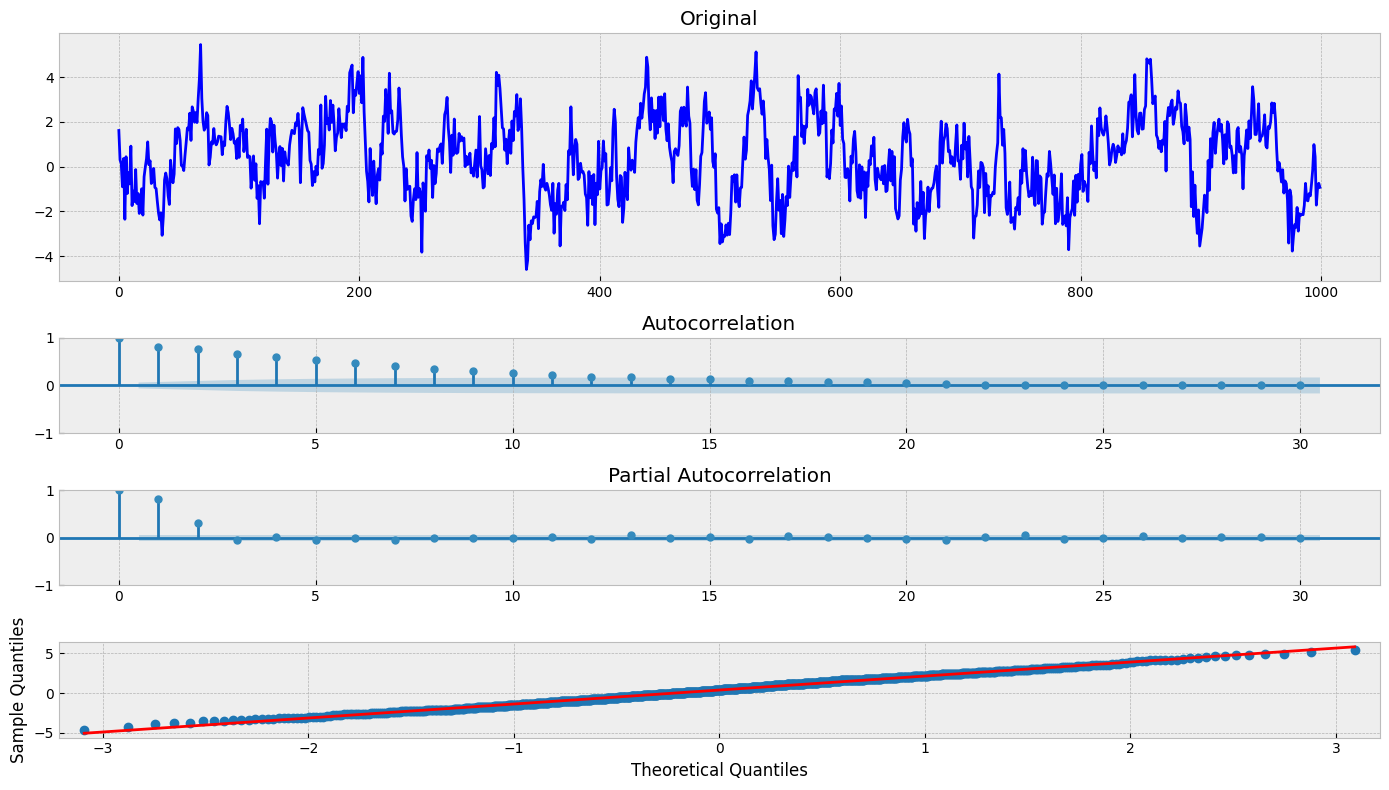

In [ ]:
# Самостоятельно генерируем данные для модели
np.random.seed(1)
n_samples = int(1000)
a1 = 0.6
a2 = 0.3

x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]

tsplot(x, lags=30)

In [ ]:
# Строим модель авторегрессии на 3 лага
mdl = AutoReg(endog=x, lags=3, trend='n', seasonal=False, old_names=False)
res = mdl.fit()
# И заставляем подобрать правильный порядок
sel = ar_select_order(endog=x, maxlag=3, ic='aic', trend='n', seasonal=False, glob=True, old_names=False)
print(sel.ar_lags)
print('\nalpha estimate: {}'.format(res.params))

[1, 2]

alpha estimate: [ 0.57237228  0.34300155 -0.0433057 ]


к-ты очень похожи на исходные, но так как при генерации мы использовали шум, то точного сопадения нет. И вначеле модель нашла 3 порядка и , соответственно, посчитала 3 к-та. Пришлось использовать ф-ю ar_select_order и вводить штраф ввиде ic='aic'. В этом случае было выявлено 2 порядка, а к-ты получились очень похожими на истинные

In [ ]:
mdl = AutoReg(endog=x, lags=2, trend='n', seasonal=False, old_names=False)
res = mdl.fit()
print('\nalpha estimate: {}'.format(res.params))


alpha estimate: [0.55910188 0.3181094 ]


Results of Dickey-Fuller Test:
Test Statistic                 -31.204247
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    997.000000
Critical Value (1%)             -3.436926
Critical Value (5%)             -2.864443
Critical Value (10%)            -2.568316
dtype: float64


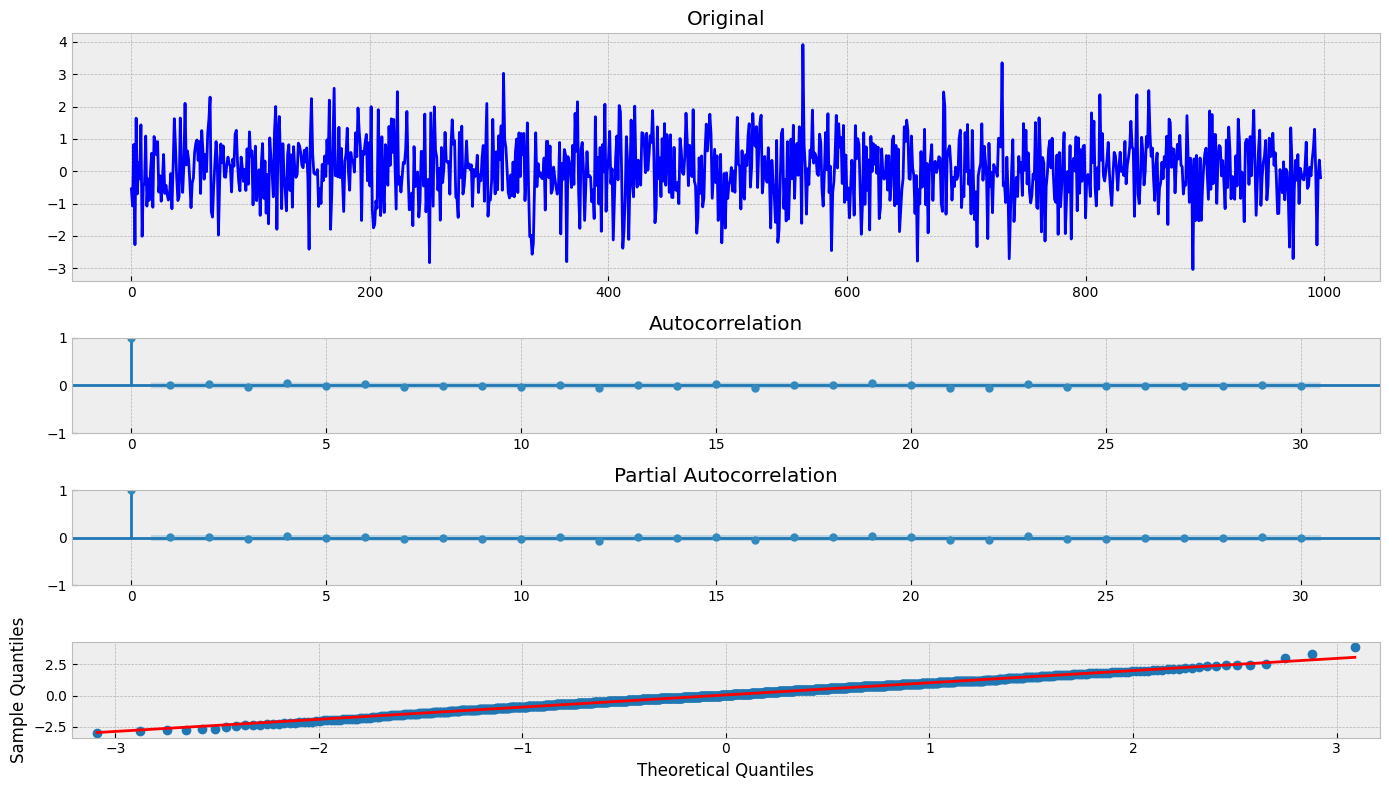

In [ ]:
tsplot(res.resid, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


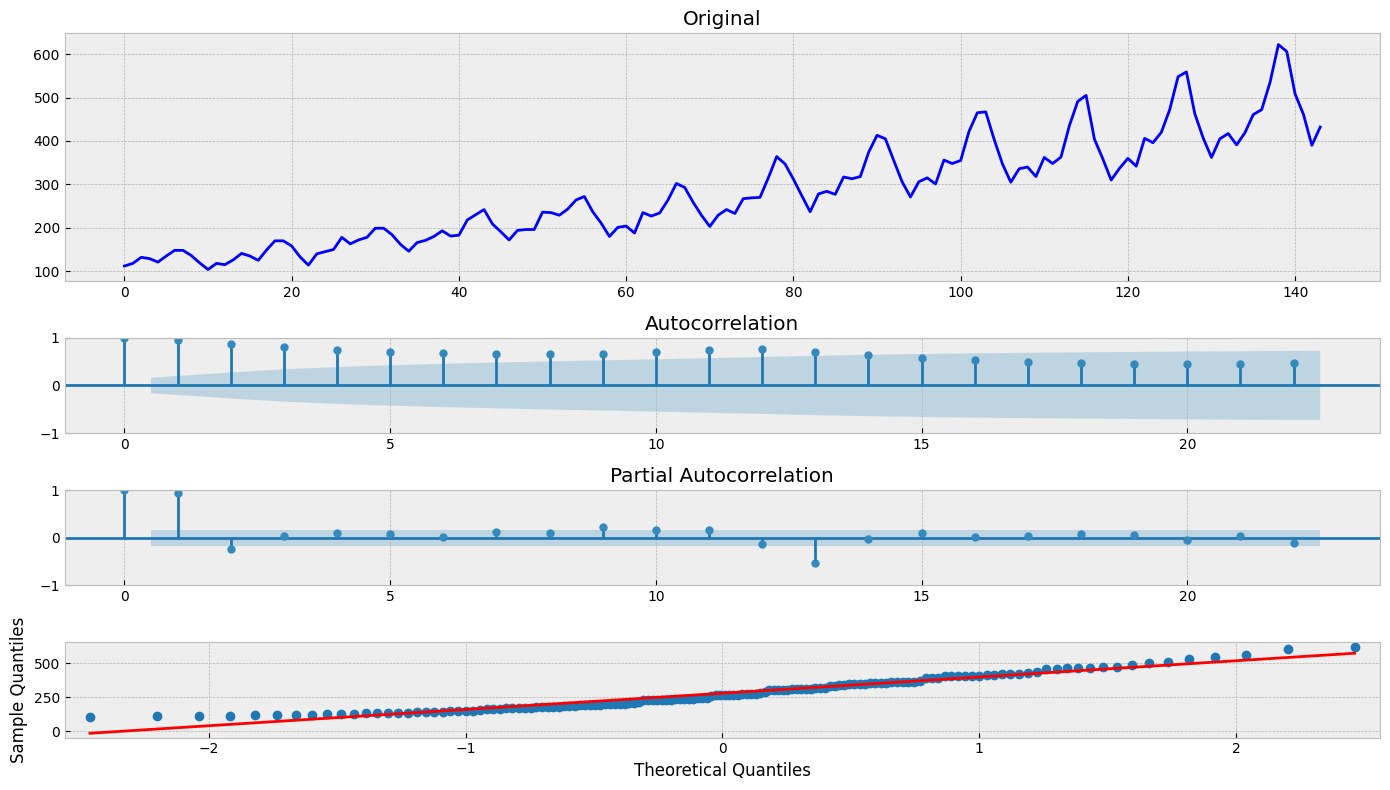

In [7]:
# Проверим, как модель авторегрессии работает на реальных рядах
series = pd.read_csv("/content/drive/MyDrive/TSML13_DZ1/Series/international-airline-passengers.csv")['Count']
tsplot(series)

Видно, что ряд не стационарен, дисперсия не нормирована, есть тренд и сезонность

In [8]:
series = boxcox(series, 0) # Нормируем дисперсию и все перестравиваем

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


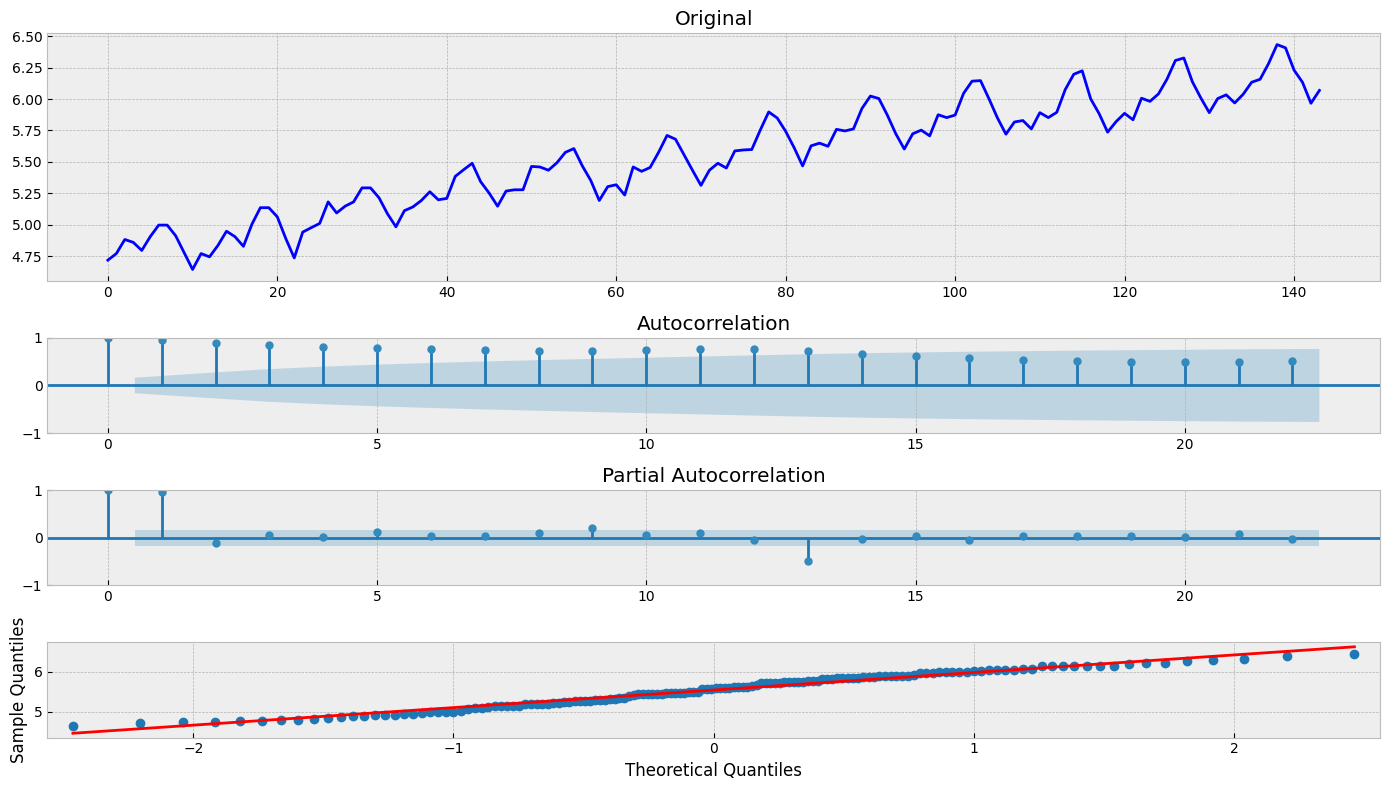

In [9]:
tsplot(series)

Дисперсию поправили, но тренд и сезонность никуда не делись. Ряд по-прежнему нестационарен

In [10]:
# Пробуем засунуть данные как есть. Берем порядок на пробу 10 лвагов ( на 30 как в лекции не хватило оперативки)
# Наличие тренда и сезонности игнорируем - эксперимент!
mdl = AutoReg(endog=series, lags=10, trend='n', seasonal=False, old_names=False)
res = mdl.fit()
# Ищем правильный порядок
sel = ar_select_order(endog=series, maxlag=10, ic='aic', trend='n', seasonal=False, glob=True, old_names=False)
print(sel.ar_lags)
print('\nalpha estimate: {}'.format(res.params))

[1, 2, 4, 5, 8, 9, 10]

alpha estimate: [ 0.93945829 -0.19117232  0.11276745 -0.4157702   0.36189269  0.02034622
  0.00171333 -0.35126224  0.30211316  0.22581375]


In [11]:
print(res.params)

[ 0.93945829 -0.19117232  0.11276745 -0.4157702   0.36189269  0.02034622
  0.00171333 -0.35126224  0.30211316  0.22581375]


In [12]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  144
Model:                    AutoReg(10)   Log Likelihood                 150.657
Method:               Conditional MLE   S.D. of innovations              0.079
Date:                Tue, 21 Nov 2023   AIC                           -279.314
Time:                        13:40:49   BIC                           -247.437
Sample:                            10   HQIC                          -266.360
                                  144                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.9395      0.085     11.080      0.000       0.773       1.106
y.L2          -0.1912      0.116     -1.648      0.099      -0.418       0.036
y.L3           0.1128      0.113      0.997      0.3

ф-я ar_select_order() проредила порядки, уменьшив до 7

In [13]:
# Повторно обучим модель, используя найденный порядок. Тренд и сезонность пока по-прежнему игнорируем
mdl = AutoReg(endog=series, lags=[1, 2, 4, 5, 8, 9, 10], trend='n', seasonal=False, old_names=False)
res = mdl.fit()

print('\nalpha estimate: {}'.format(res.params))


alpha estimate: [ 0.93113074 -0.12697656 -0.34617665  0.36380095 -0.34608966  0.31334798
  0.21683702]


In [14]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  144
Model:             Restr. AutoReg(10)   Log Likelihood                 150.059
Method:               Conditional MLE   S.D. of innovations              0.079
Date:                Tue, 21 Nov 2023   AIC                           -284.118
Time:                        13:40:53   BIC                           -260.935
Sample:                            10   HQIC                          -274.697
                                  144                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.9311      0.077     12.146      0.000       0.781       1.081
y.L2          -0.1270      0.084     -1.512      0.131      -0.292       0.038
y.L4          -0.3462      0.083     -4.155      0.0

Results of Dickey-Fuller Test:
Test Statistic                  -2.068458
p-value                          0.257385
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


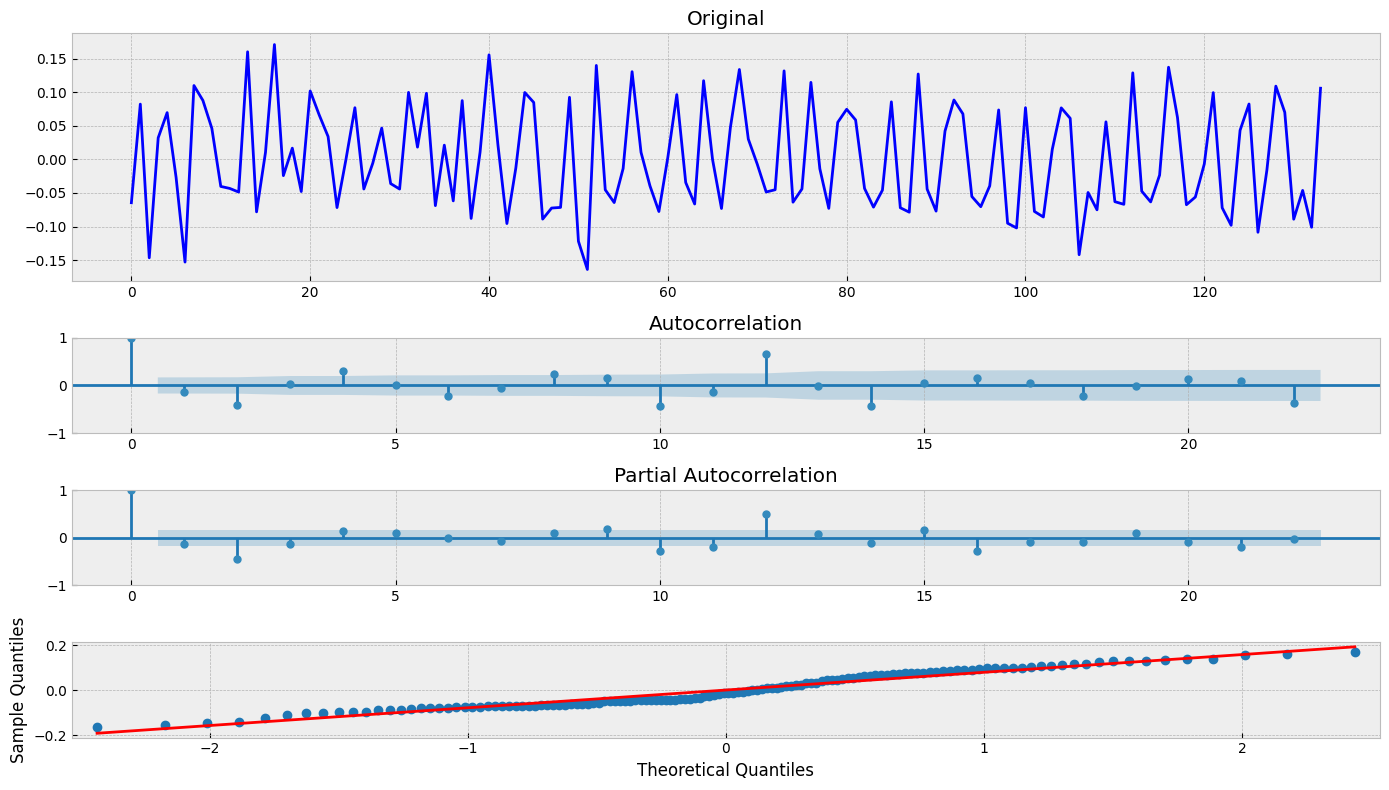

In [15]:
tsplot(res.resid)

График стал получше, но все равно до идеала далеко. Сезонность не учитывали, и тренд тоже. Ряд нестационарен, и это видно и по статистикам, и визуально. Следовательно, модель получится ненадежная, качекство предсказаний будет низкое

Можно попробовать выполнить преобразования над рядом, удалив тренд и сезонность и приведя его к стационарности, а можно добавить в ф-ю AutoReg параметры тренда и сезонности. Попробуем второй вариант

In [16]:
mdl = AutoReg(endog=series, lags=[1, 2, 4, 5, 8, 9, 10], trend='t', seasonal=True, period=12, old_names=False)
res = mdl.fit()
sel = ar_select_order(endog=series, maxlag=7, ic='aic', trend='t', seasonal=True, period=12, glob=True, old_names=False)
print(sel.ar_lags)
print('\nalpha estimate: {}'.format(res.params))

[1, 2, 4, 5]

alpha estimate: [ 0.00097645  0.52575011  0.48786783  0.62793672  0.54406854  0.50573722
  0.63311939  0.69886034  0.61392405  0.4401872   0.4118607   0.39724415
  0.57571954  0.63227163  0.17702872 -0.17873388  0.19380754 -0.13527052
  0.19232718  0.01238714]


In [17]:
print(res.summary())

                               AutoReg Model Results                                
Dep. Variable:                            y   No. Observations:                  144
Model:             Restr. Seas. AutoReg(10)   Log Likelihood                 267.471
Method:                     Conditional MLE   S.D. of innovations              0.033
Date:                      Tue, 21 Nov 2023   AIC                           -492.942
Time:                              13:41:01   BIC                           -432.087
Sample:                                  10   HQIC                          -468.213
                                        144                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.0010      0.001      1.453      0.146      -0.000       0.002
s(1,12)        0.5258      0.314      1.676      0.094      -0.089       1.141
s(2,

Ф-я потеры увеличилась, и штрафы тоже выросли. Тест дики-фуллера показывает, что ряд стационарен. Одднако визуально график остатков не похож на белый шум, как это должно быть, и qq график также не показывает нормального распределения остатков

Results of Dickey-Fuller Test:
Test Statistic                -1.152418e+01
p-value                        3.973080e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.330000e+02
Critical Value (1%)           -3.480500e+00
Critical Value (5%)           -2.883528e+00
Critical Value (10%)          -2.578496e+00
dtype: float64


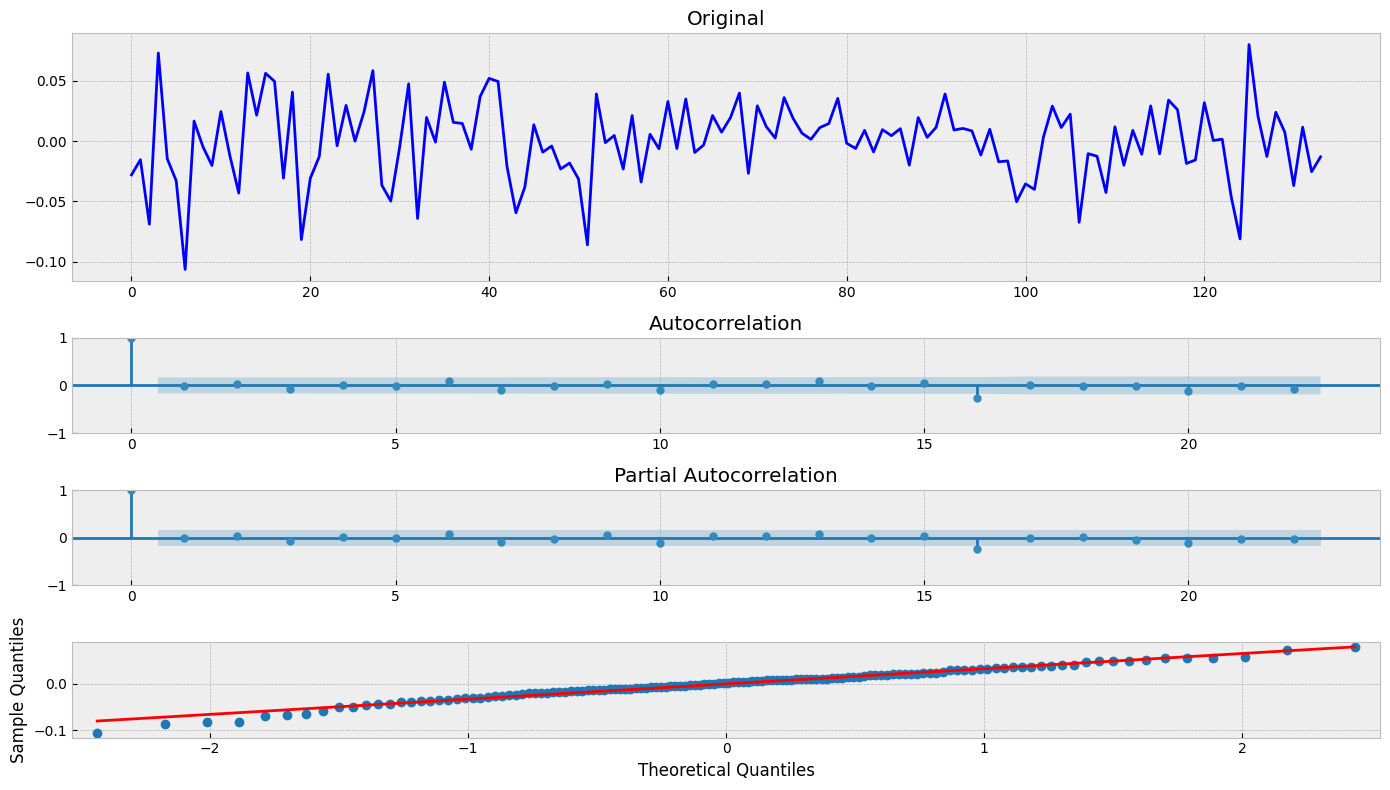

In [18]:
tsplot(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


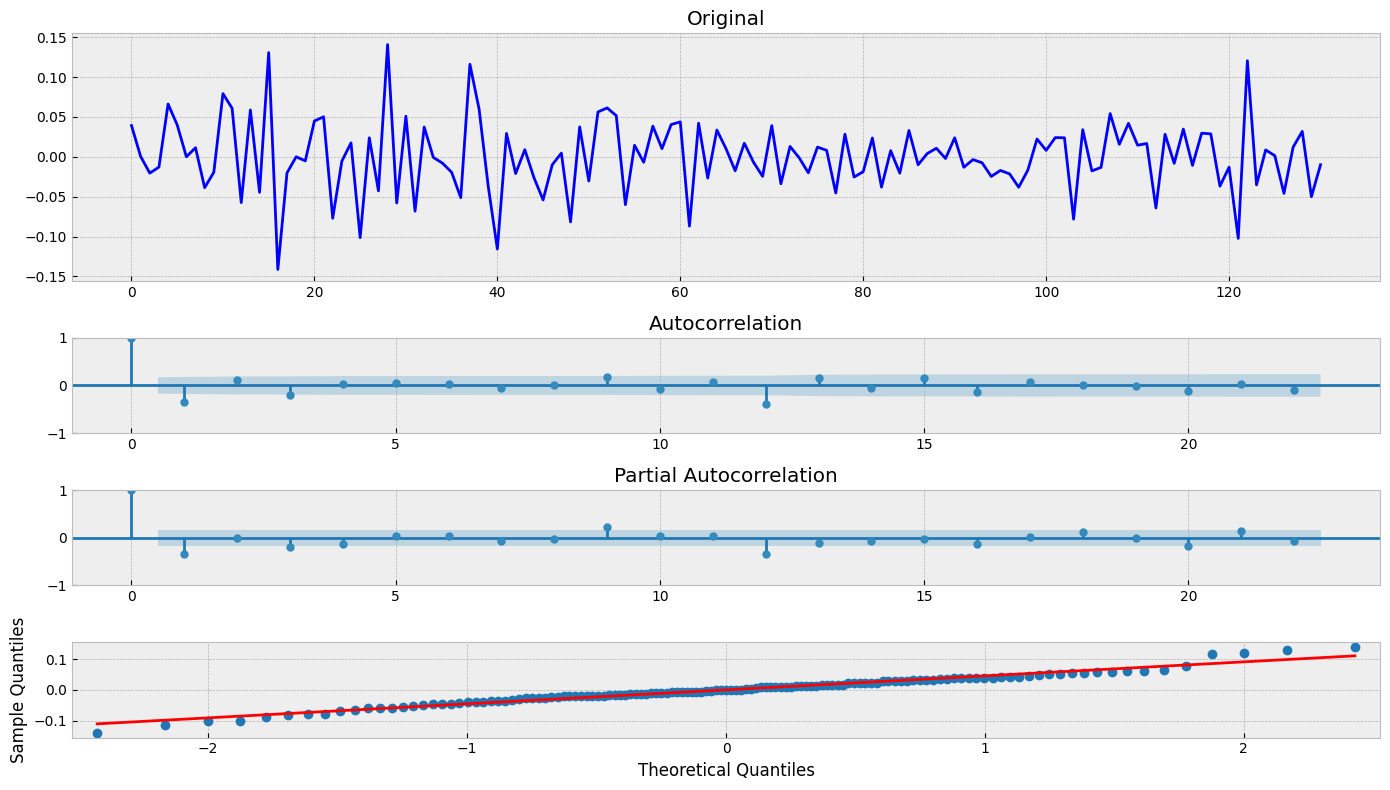

In [19]:
# Пробуем удалить тренд
series_diffed = np.diff(series)
# И избавиться от сезонности
series_diffed = series_diffed[12:] - series_diffed[:-12]
tsplot(series_diffed)

Тести дики фуллера показывает стационарность. но нормальности в распределении серии пока нет

In [20]:
# опять строим модель авторегрессии, используя найденные ранее порядки. Т.к сезонность и тренд убрали, то используем seasonal=False и trend=n'
mdl = AutoReg(endog=series_diffed, lags=[1, 2, 4, 5], trend='n', seasonal=False, old_names=False)
res = mdl.fit()

print('\nalpha estimate: {}'.format(res.params))


alpha estimate: [-0.34816459  0.00891082 -0.04216183  0.0513442 ]


In [22]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  131
Model:              Restr. AutoReg(5)   Log Likelihood                 217.507
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Tue, 21 Nov 2023   AIC                           -425.015
Time:                        13:41:56   BIC                           -410.833
Sample:                             5   HQIC                          -419.253
                                  131                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1          -0.3482      0.090     -3.854      0.000      -0.525      -0.171
y.L2           0.0089      0.091      0.098      0.922      -0.169       0.187
y.L4          -0.0422      0.091     -0.465      0.6

Results of Dickey-Fuller Test:
Test Statistic                  -4.732506
p-value                          0.000073
#Lags Used                      11.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


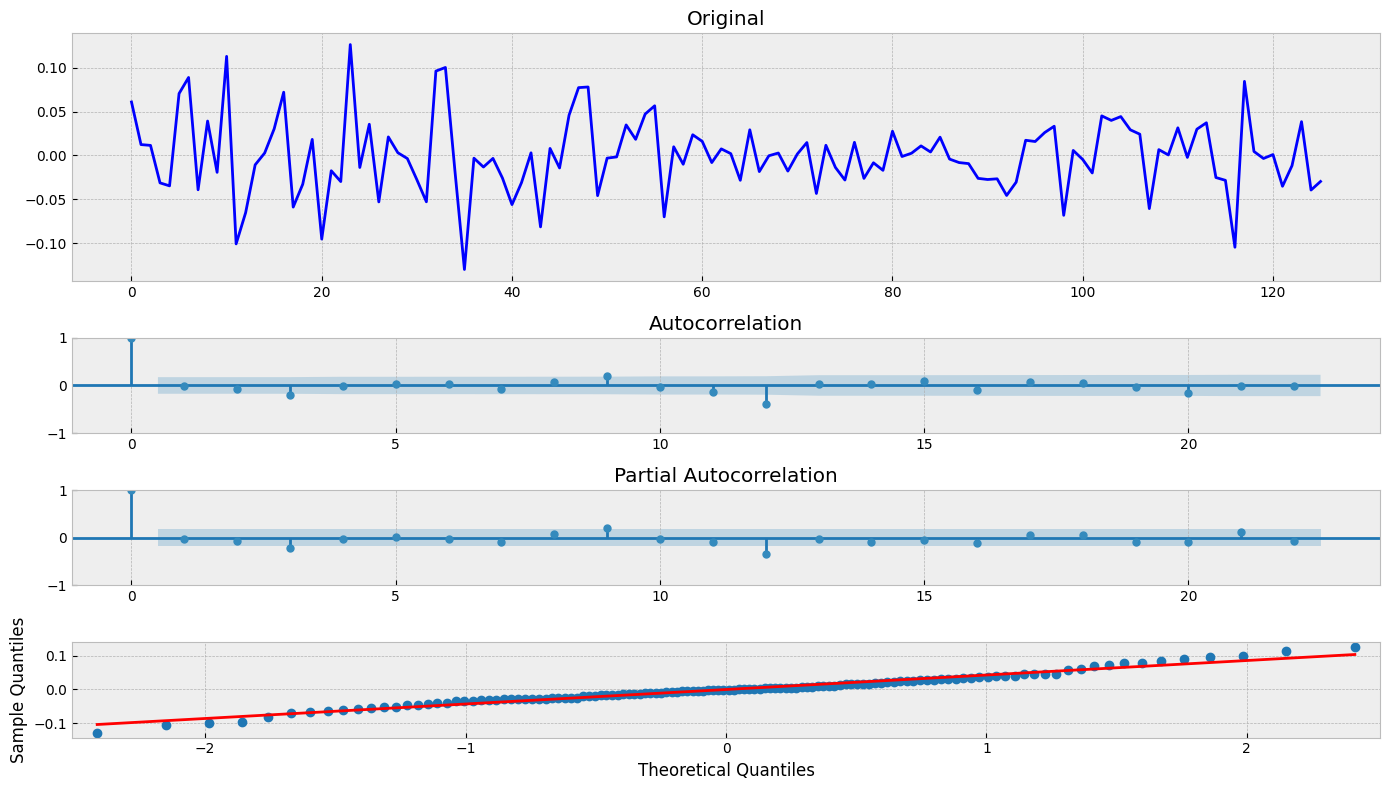

In [24]:
tsplot(res.resid)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на значениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA

Results of Dickey-Fuller Test:
Test Statistic                -1.707000e+01
p-value                        7.837586e-30
#Lags Used                     1.700000e+01
Number of Observations Used    4.982000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64


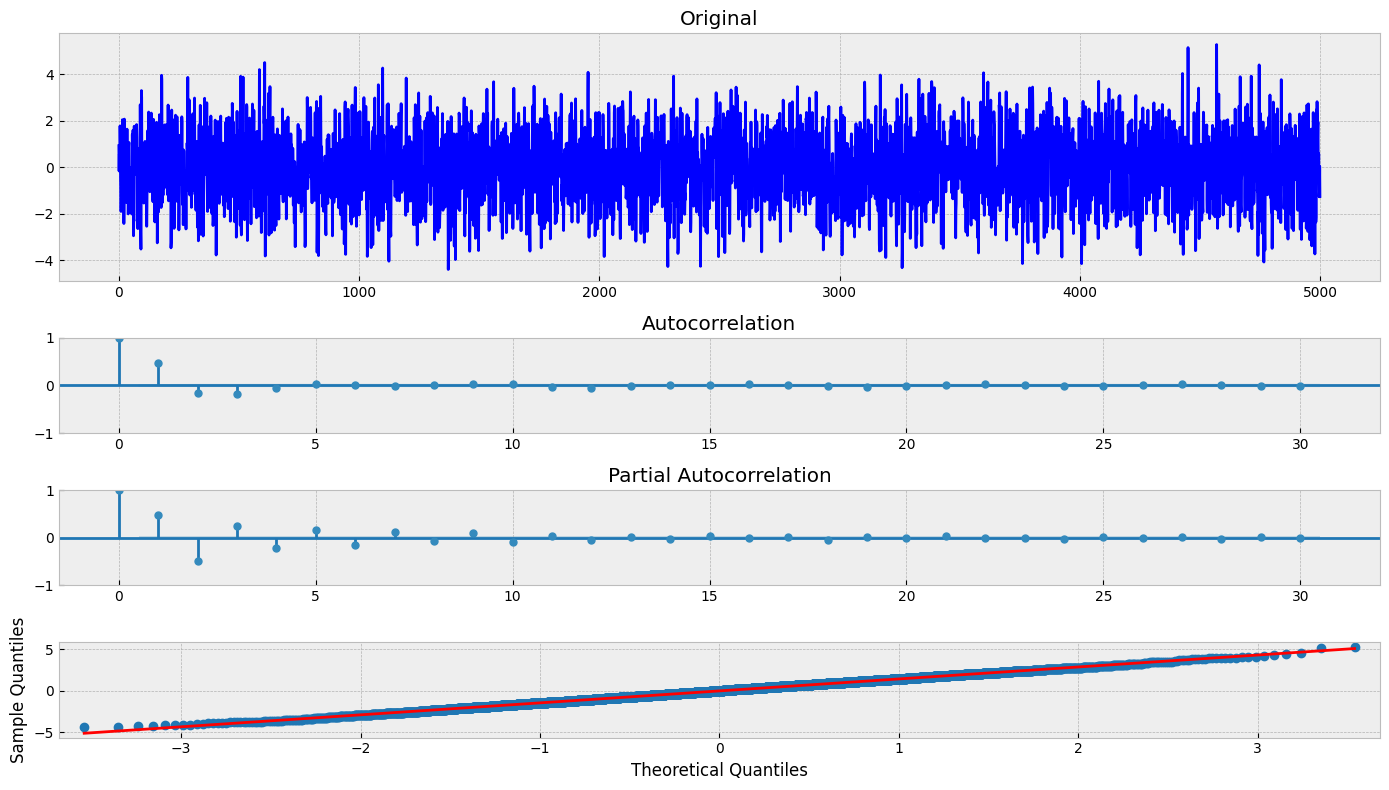

In [33]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
# alphas - это набор к-тов ai, betas - набор к-тов Bi
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas] #создает новый массив, где первый элемент равен 1, а остальные элементы равны отрицательным значениям из массива alphas
ma = np.r_[1, betas] # создает новый массив, где первый элемент равен 1, а остальные элементы равны значениям из массива betas

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

In [53]:
# Сгенерируем датасет для ARMA(2,2)
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(12345)
# include zero-th lag
n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit
arparams = np.array([0.5, -0.25])
maparams = np.array([0.5, -0.3])
# Здесб мы инициализируем процесс, в соответсвии со свойставми которого будет генерироватся временной ряд
arma_t = ArmaProcess(ar=arparams, ma=maparams)
print(arma_t.isinvertible, arma_t.isstationary)
print(arma_t.arroots)
# Это   мы генерируем значения x или endogs
arma_rvs = arma_t.generate_sample(nsample=5000, burnin=burn, scale=2.5) # burnin -Number of observation at the beginning of the sample to drop. Used to reduce dependence on initial values

True True
[2.]


In [54]:
# С помощью ARIMA задаются AR(p), MA(q), ARMA(p,q), ARIMA(p,d, q),  SARIMA(P,D,Q,S)
# MA(q) = ARIMA(0,0,2)
# ARMA(p,q) = ARIMA(p,0,q)
mdl = ARIMA(endog=arma22, order=(2, 0, 2), trend='n', enforce_stationarity=True).fit()
print(mdl.params)
print(mdl.summary())

[ 0.50170888 -0.23216001  0.487766   -0.32295464  1.00159928]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7099.617
Date:                Tue, 21 Nov 2023   AIC                          14209.235
Time:                        15:25:37   BIC                          14241.821
Sample:                             0   HQIC                         14220.656
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5017      0.061      8.159      0.000       0.381       0.622
ar.L2         -0.2322      0.015    -15.211      0.000      -0.262   

In [65]:
sm.stats.durbin_watson(mdl.resid)
# Тест Дурбин=ватсон на коррелированность ьостатков. В пределах 0-4.
# Близко к нулю - сильная положительная корреляция
# Близко к 4 - сильная отрицательная корреляция
# 2 - нет корреляции

2.0008830070693837

Results of Dickey-Fuller Test:
Test Statistic                  -70.754478
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    4999.000000
Critical Value (1%)              -3.431659
Critical Value (5%)              -2.862118
Critical Value (10%)             -2.567078
dtype: float64


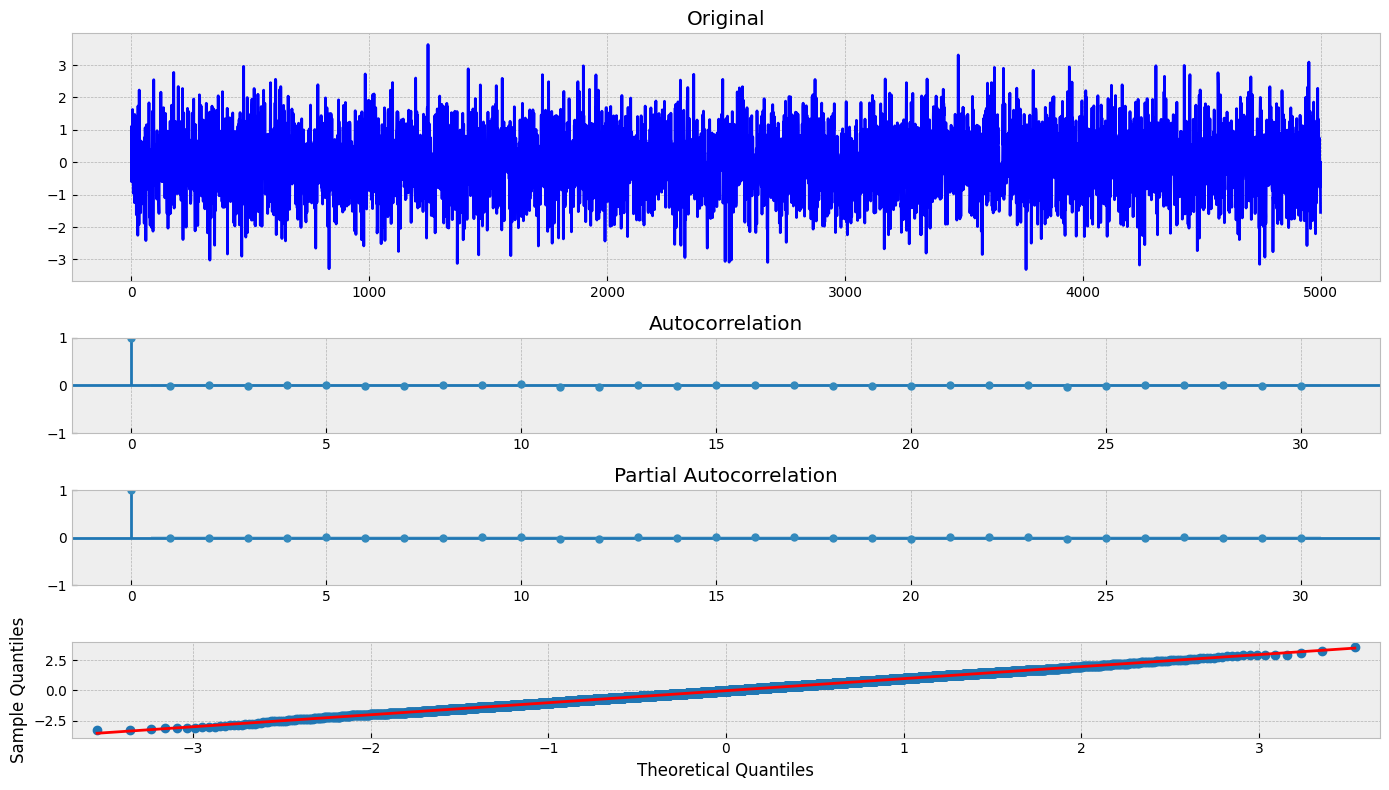

In [67]:
tsplot(mdl.resid, lags=max_lag)

In [61]:
mdl.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 2,
 'ma': 2,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 2,
 'reduced_ma': 2,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [74]:
mdl.aic

14209.234959481271

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

In [76]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            # tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc')
            tmp_mdl = ARIMA(endog=arma22, order=(i, 0, j), trend='n', enforce_stationarity=True).fit()
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 17822.69099 | order: (0, 0)
aic: 14429.45884 | order: (0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


aic: 14375.14475 | order: (0, 2)
aic: 14266.07764 | order: (0, 3)
aic: 14211.71400 | order: (0, 4)
aic: 16554.36790 | order: (1, 0)
aic: 14394.21550 | order: (1, 1)
aic: 14341.37571 | order: (1, 2)
aic: 14225.06377 | order: (1, 3)
aic: 14213.47679 | order: (1, 4)
aic: 15209.44641 | order: (2, 0)
aic: 14233.88964 | order: (2, 1)
aic: 14209.23496 | order: (2, 2)
aic: 14210.81997 | order: (2, 3)
aic: 14212.48749 | order: (2, 4)
aic: 14882.53752 | order: (3, 0)
aic: 14210.12383 | order: (3, 1)
aic: 14210.71398 | order: (3, 2)
aic: 14213.04759 | order: (3, 3)
aic: 14214.24467 | order: (3, 4)
aic: 14651.53173 | order: (4, 0)
aic: 14210.98723 | order: (4, 1)
aic: 14212.52558 | order: (4, 2)
aic: 14214.65112 | order: (4, 3)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


aic: 14215.64131 | order: (4, 4)
aic: 14209.23496 | order: (2, 2)


Применим модель ARMA к нашей TS

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


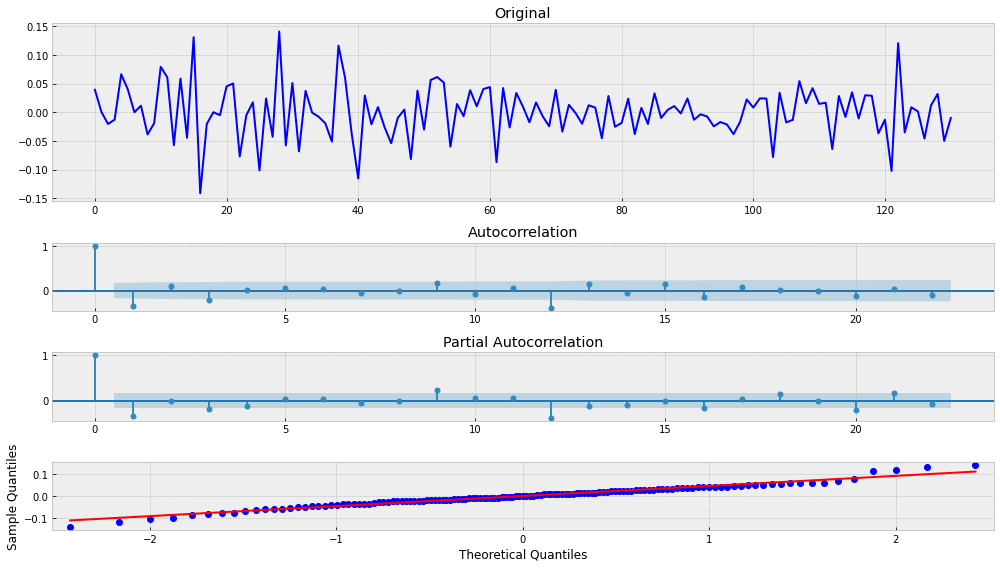

In [ ]:
series = pd.read_csv("../1. Лекция/Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

In [ ]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(series, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_mod

aic: -461.63881 | order: (4, 4)


/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian fai

Results of Dickey-Fuller Test:
Test Statistic                  -4.343319
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


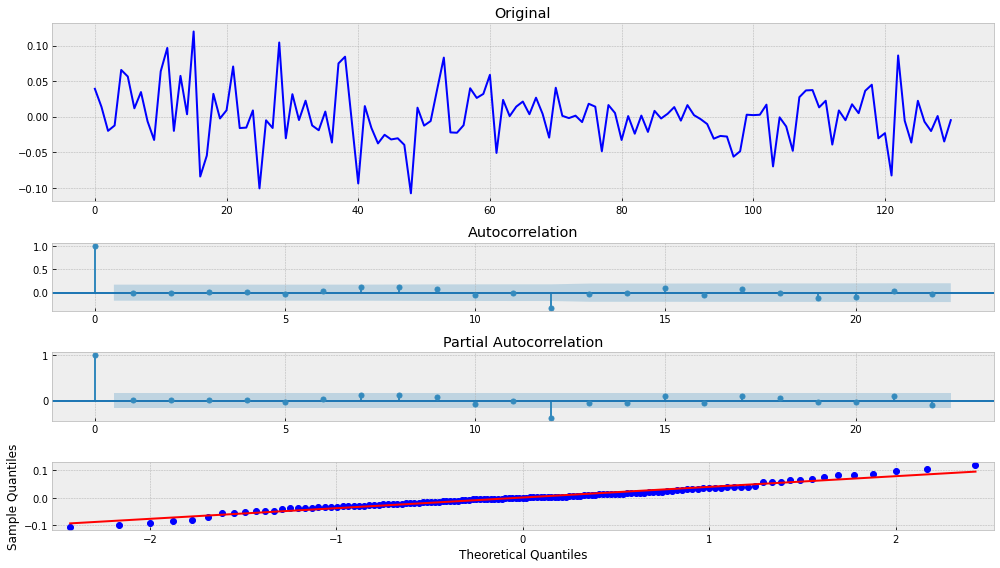

In [ ]:
mdl = smt.ARMA(series, order=(4, 4)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl.resid)

Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

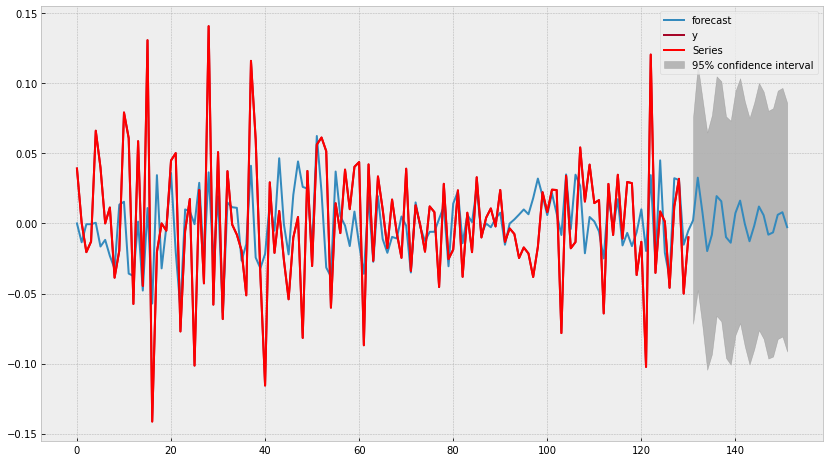

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
series = pd.read_csv("/content/drive/MyDrive/TSML13_DZ1/Series/international-airline-passengers.csv")['Count']

In [ ]:
tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

aic:    inf | order: None


AttributeError: ignored

In [ ]:
best_mdl

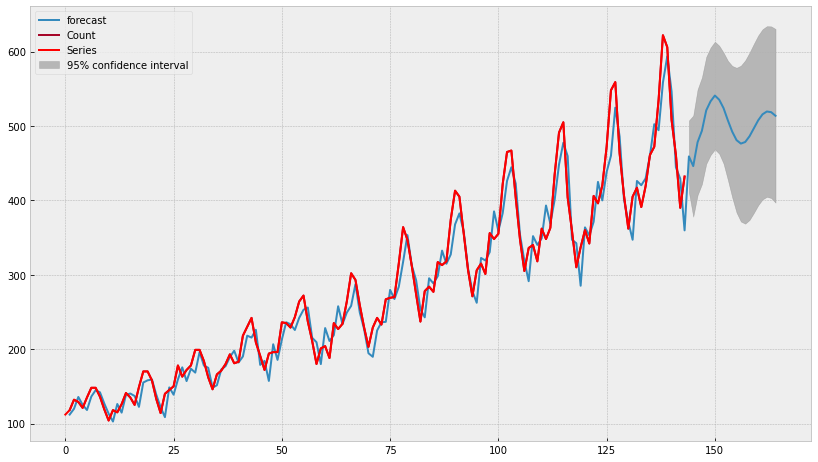

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


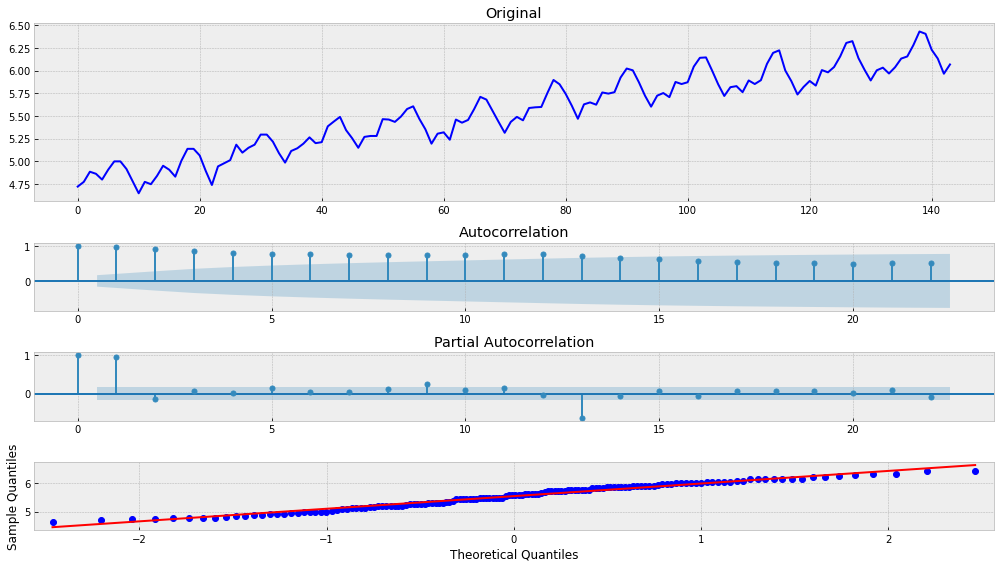

In [ ]:
series = pd.read_csv("../1. Лекция/Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
tsplot(series)

/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_mod

aic: -294.55887 | order: (4, 2, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -2.257747
p-value                          0.185958
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


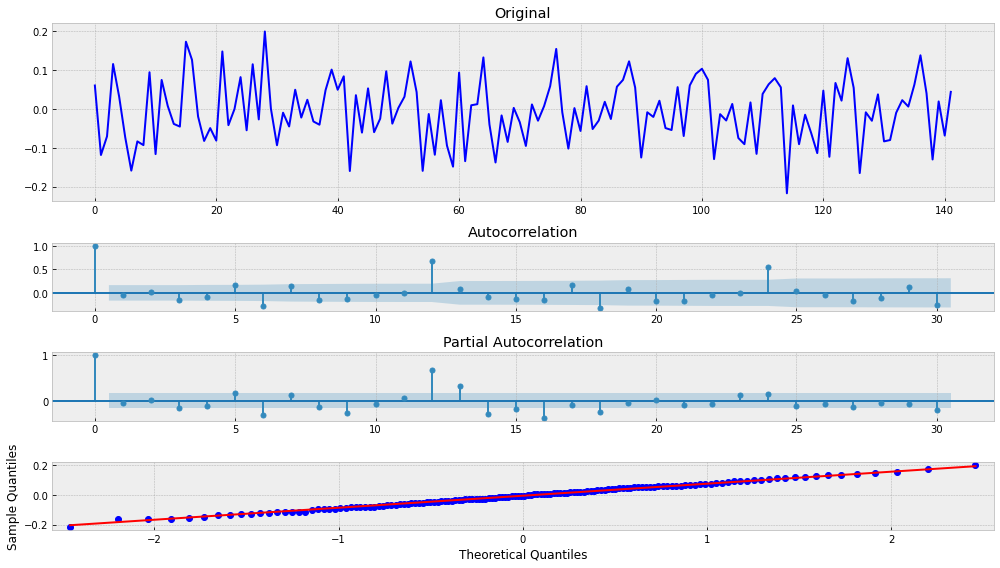

In [ ]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


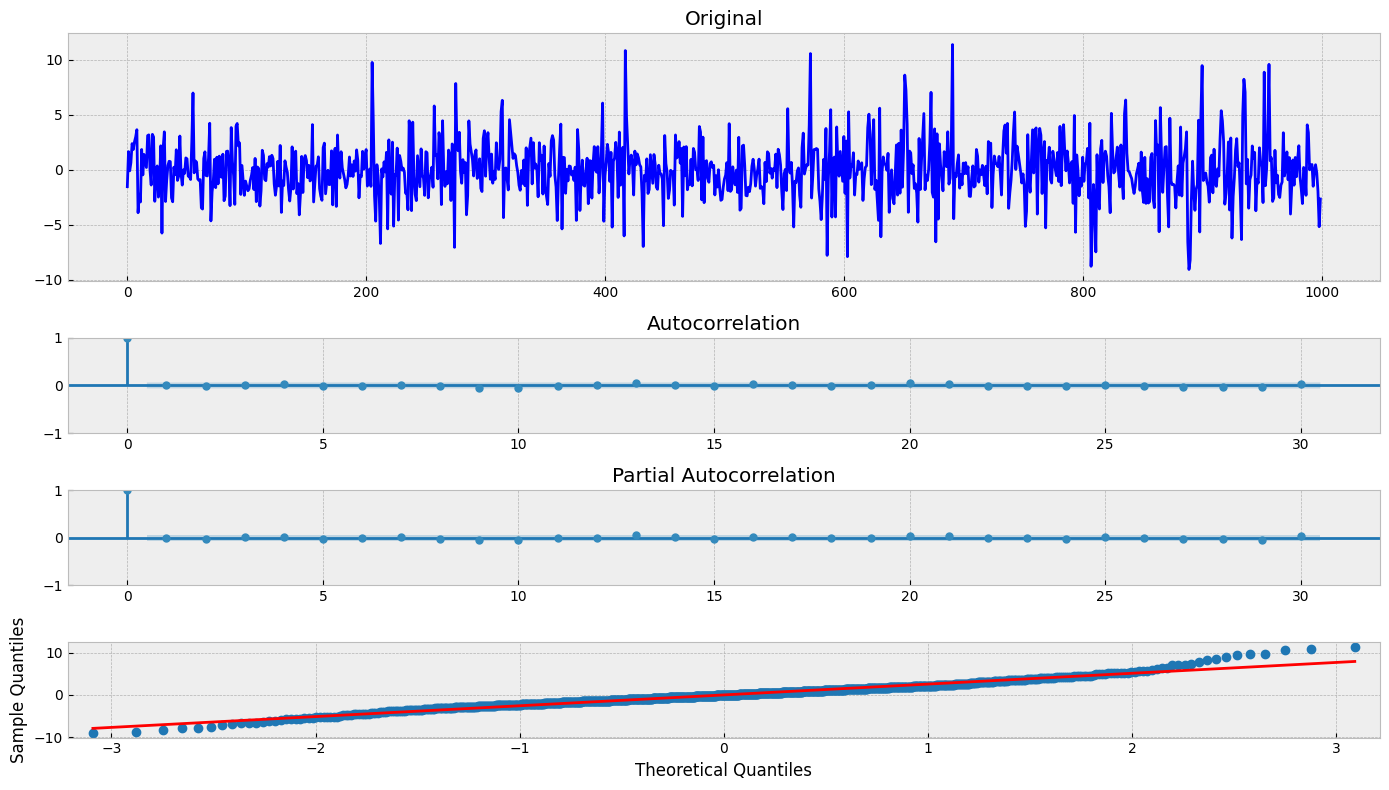

In [ ]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [ ]:
from arch import arch_model

ModuleNotFoundError: ignored

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


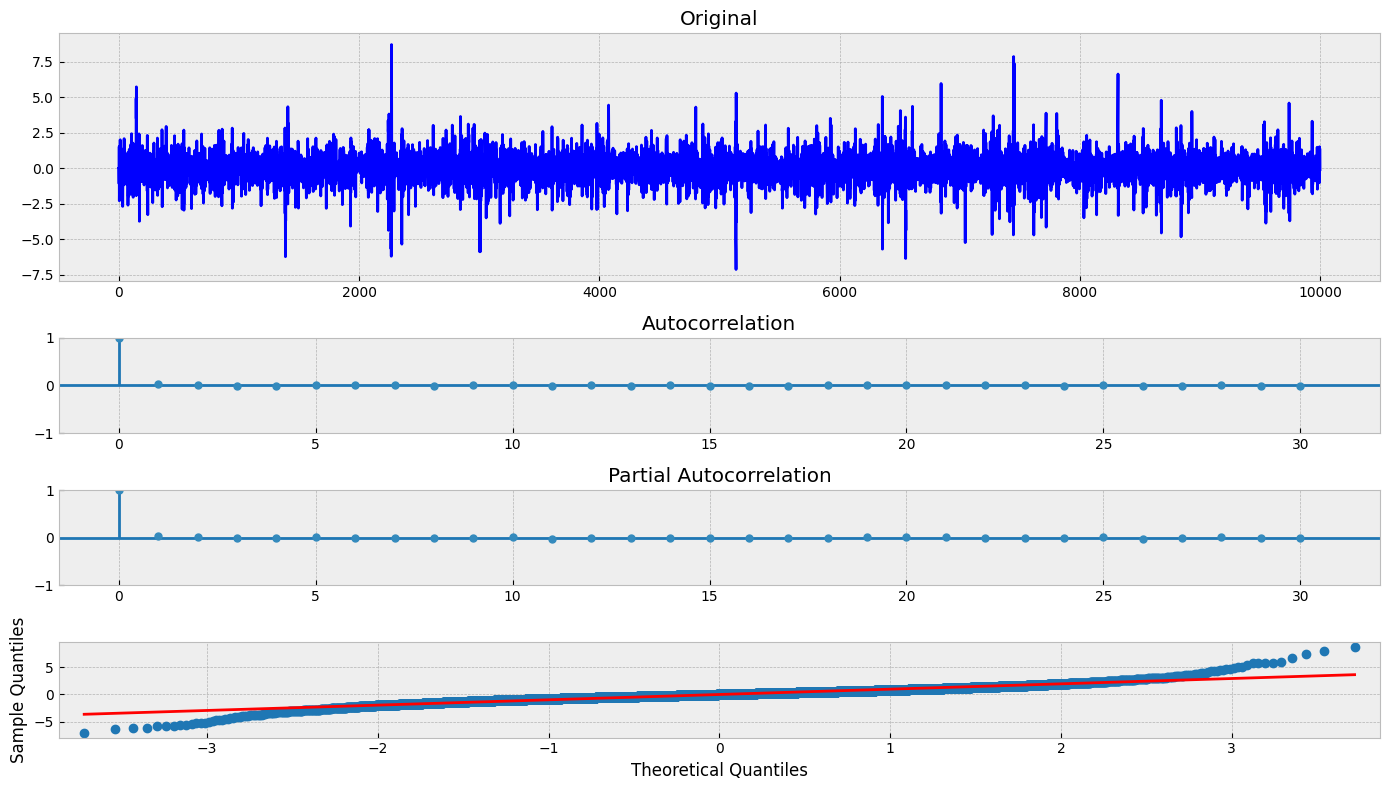

In [ ]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [ ]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

NameError: ignored

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic:    inf | order: None


In [ ]:
tsplot(mdl.resid)

Применим GARCH

In [ ]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 0
q_ = 4

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

In [ ]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

In [ ]:
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [ ]:
aic, order, mdl = _get_best_model(new_series)


In [ ]:
tsplot(mdl.resid)

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

In [ ]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [ ]:
series = pd.read_csv("../1. Лекция/Series/international-airline-passengers.csv")

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

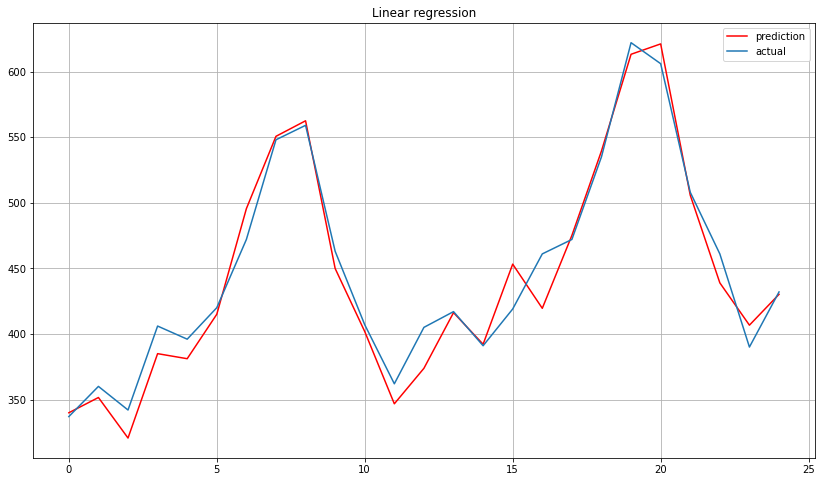

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016